---
> 流行は色褪せるけど、スタイルだけは不変です  
> ココ・シャネル
---

# StyleGANについて学ぶ

既にStyleGAN2に加えて、StyleGAN3が登場し、PyTorchでも動作するようになった
- とはいえ、Colabで動作させるには様々準備が必要で、間に合っていない…

## StyleGANの導入

この回はGoogle Driveを利用し、その空き容量として2.5Gバイト程度必要である
- 容量に余裕のない学生は、コードを書き替えて対応可能であるが、苦労して取得、変換したデータがセッション終了とともに消えてなくなることに注意すること
- できれば新たなアカウントを取得するなどして空き容量のあるアカウントで実習されたい
  - 無料アカウントは15G提供されるためかなり余裕がある
- 企業やアカデミックアカウント(keio.jpを含む)で容量無制限の場合は、遠慮なくこれを使おう
- 各種ファイルを保存するパスは各自で設定できるが、下記は推奨パス名である
  - パス名にスペースが入らないようにすること
  - 入ると途中処理が実行できないnVidia提供コードが存在する

StyleGANはnVidiaが提供するコードが存在し、Tensorflowを利用して記述されている
- 従って、感覚は理解できるが、PyTorchの知識が利用できない
  - 後で述べるが、StyleGAN3はPyTorchに変更された
  - しかしながら、メモリサイズが大きすぎ、簡単には実行できない
- StyleGANは提供されるコードは機能ごとによくまとまって実装されており、各提供機能を操作するだけでも様々なことができる
- ということで、今回はPyTorch以外のシステムにも触れてみるということと、いつもとは少し違う観点で学んでみる

今回、Google Colaboratory上で実行させるために、いくつかのコード修正を行っている

そこで、まず普通にStyleGANを利用する場合の手順について、参考程度に記載する
- nVidia提供コードはGitHubに存在するため、次のコマンドでレポジトリのクローンとしてのコピーをローカルに作成する
  - `!git clone https://github.com/NVlabs/stylegan.git`
  - これを実行すれば展開できるが、このままでは実行することができない
  - 不足している事前学習済みモデルも提供されており、これを利用する
    - 次のリンクから、ファイルをダウンロードして、StyleGANの事前学習モデルを入手する
    - `https://drive.google.com/drive/folders/1MASQyN5m0voPcx7-9K0r5gObhvvPups7`

なお、以下はこちらから提供する事前学習モデル込みの圧縮ファイルを利用する


では早速、学習キットをダウンロードして導入する
- ファイルサイズが1.5G弱あるため注意する

In [ ]:
import os
if not os.path.exists('stylegan'):
  !wget https://keio.box.com/shared/static/tnuuo9pmwxq75b01fyocchw7z5qdtspw -O stylegan.zip
  !unzip stylegan.zip
%cd stylegan

--2021-12-11 16:36:21--  https://keio.box.com/shared/static/tnuuo9pmwxq75b01fyocchw7z5qdtspw
Resolving keio.box.com (keio.box.com)... 107.152.24.197
Connecting to keio.box.com (keio.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/tnuuo9pmwxq75b01fyocchw7z5qdtspw [following]
--2021-12-11 16:36:21--  https://keio.box.com/public/static/tnuuo9pmwxq75b01fyocchw7z5qdtspw
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/tnuuo9pmwxq75b01fyocchw7z5qdtspw [following]
--2021-12-11 16:36:22--  https://keio.app.box.com/public/static/tnuuo9pmwxq75b01fyocchw7z5qdtspw
Resolving keio.app.box.com (keio.app.box.com)... 107.152.24.201
Connecting to keio.app.box.com (keio.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!1dE_I

次に、tensorflowのバージョンが問題となるため、v1を利用するように設定する

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## StyleGANを試しに実行してみる

まずは、StyleGANとはどういうものかをみてみよう

セルの中のコードでは実行できないため、直接呼び出して実行させる
- ちょっと残念だが、コードは左のファイル一覧から`pretrained_example.py`をクリックすると、ウィンドウ下に表示され、Colab上で編集も可能となる
- 実行し、ファイルの再表示ボタンを押すと、このディレクトリに`results`フォルダが新たに生成される
- このフォルダの中にある`example.png`が生成された画像である
- 例えば、`rnd = np.random.RandomState(5)`の5を変えると、潜在ベクトルをランダムに選択するようになるため、異なる顔をいくらでも生成できる

In [ ]:
!python pretrained_example.py














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/De

## StyleGANの動作内容を確認する

実際に、resultsフォルダを見て生成画像を確認しよう
- サイズが大きいため、Notebookには掲載しないが、高いクオリティを有する人物画像が生成されていることがわかる
- 自動生成であり「実際には存在しない人物」である

## StyleGANの動作内容を理解する

### PG-GANの応用

ではなぜ、StyleGANはこのような高解像度かつ自然な画像を生成できるのか
- 大きな画像生成では伝搬情報が薄れ高精細な画像が得られなかった
- この問題を解決する基本はProgressive Growing GAN (PG-GANと表記)

<img src="http://class.west.sd.keio.ac.jp/dataai/text/sg-pggan.jpg" width=600>

- 4x4の小さな画像から段階的に画像を大きくし、最終的に1024x1024の画像を得る
  - 結果的に学習を安定化できる
- 画像の解像度を上げる際にも畳み込みを行った画像へと変換するが、$1-\alpha:\alpha$という内分比を徐々にずらして実施することで安定した学習ができるように工夫している

<img src="http://class.west.sd.keio.ac.jp/dataai/text/sg-pggan2.jpg" width=600>

例えば`16x16`から
`32x32`など、解像度を上げる際には畳み込みを利用
- 但し、いきなり畳み込みを行わず、隣接ピクセルをコピーするというシンプル手法である最近傍フィルタリングで縦横それぞれ2倍に拡大させた画像から、徐々に畳み込みを行った画像とする
- 最終的には$\alpha = 1$として畳み込み画像と同一にする
- ResNetの残差ブロック(ショートカットパス)と同じ意味を持つ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/residual_block.jpg" width=300>



### マッピングネットワーク(Mapping Network)

その`4x4`から`8x8`に拡張する際の処理がPG-GANとStyleGANでは多少異なる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/pg-gan2.png" width=150>
<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-mn.png" width=150>

- 左図はPG-GANのマッピングネットワークを表しており、ガウス分布(正規表現)に基づくノイズ(要するに乱数)を全結合・正規化・畳み込み・正規化を経て次のブロックに伝えるという処理を行う
- 右図はStyleGANのマッピングネットワークを合わしており、同様にノイズ入力を正規化した後、全結合層のみ8回繰り返すことで潜在空間表現を得る
- この潜在空間表現は、ノイズの持つ次元よりも大幅に次元拡張されている
  - 実際には512次元のベクトルが18列並んだ空間である
  - なぜ18かは後でわかる
- この潜在空間表現を得るための次元拡張手段をマッピングネットワークとよぶ

### 合成ネットワーク

上記潜在空間から顔画像を生成するネットワークを合成ネットワーク(Synthesis Network)と呼ぶ
- 得られた潜在空間をPG-GANと同様の構造で学習する

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-sn.png" width=150>

`4x4`の画像生成部
- PG-GANではノイズを与えたが、StyleGANでは定数を与える
- 定数を正規化し畳み込みを行った後再び正規化する

`8x8`の画像生成部
- アップサンプリングして画像を拡大する
- 正規化し、畳み込みを行った後再び正規化する

この後、`16x16`、`32x32`と続け、最終的に`1024x1024`の画像を得る

マッピングネットワークで得られた潜在空間の各要素を、それぞれ異なる合成ネットワーク内の異なる画像サイズに対する処理の正規化に利用する
- さらに別途ノイズ(乱数)を準備し、各ブロックの正規化前の値にバイアスとして足しこむ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-mnsn.png" width=500>

### 正規化(Normalization)

既に何度か扱っているが、ここで復習しておく

一般的には、Batch Normalizationが行なわれるが、PG-GANやStyleGANでは、正規化としてInstance Normalizationが行なわれる
- 実際の計算は平均を$\mu$、分散を$\sigma$とすると次の式に従う
  - なお、これまでもしばしば正規化項(下記大きな括弧の中・分数部分)を$Z$として表記してきたが、特にこれをZスコアと呼ぶ

$$N(x) = \gamma \left (\frac{x-\mu(x)}{\sigma(x)} \right )+\beta$$

- 実際の分散の計算においては、分母にあるため0とならないように極めて小さい値を足すという処理が追加されている
- ここでは、さらにパラメータとして$\gamma$を掛け$\beta$を足し合わせている

ここで、Normalizationについて改めてまとめておく
- Normalizationをどの範囲で行うかという適用範囲は様々あり、それぞれ名称が異なる
  - ここではCNNの表現に従い、それぞれバッチサイズ N, チャンネル数 C, 画像の縦幅 H, 画像の横幅 W としている

<img src="http://class.west.sd.keio.ac.jp/dataai/text/groupnorm-gn-zu.png" width=500>





### Style Transfer (スタイル変換)

さてここで再びスタイルトランスファーの登場であるが、StyleGANにおけるスタイル変換の基本となるAdaptive Instance Normalizationについて説明する

$$AdaIN(x,y)=\sigma(y)\left (\frac{x-\mu(x)}{\sigma(x)}\right )+\mu(y)$$

- ここで、$x$が元画像、$y$がスタイル画像である
- スタイル画像の標準をZスコアに乗じ、スタイルの平均を加えるという処理を施す
- オリジナルの画像の持つ平均や分散を、スタイル画像の持つ平均や分散に置き換えるという処理を想定している
  - 平均と分散を揃えるだけなので、前回学んだスタイルトランスファーとは処理も意味が若干異なる

StyleGANでは、この方法を踏襲し、次のような式で求める

$$AdaIN(\boldsymbol x_i,\boldsymbol y)=\boldsymbol y_{s,i}\left (\frac{\boldsymbol{x}_i-\mu(\boldsymbol{x}_i)}{\sigma(\boldsymbol{x}_i)}\right )+\boldsymbol{y}_{b,i}$$


- $\boldsymbol{x}_i$は$i$番目の元画像の特徴マップ、つまり畳み込みによって得られた特徴マップ(Feature map)のテンソルを意味する
- $\boldsymbol{y}$はマッピングネットワークの出力である潜在空間の一部を意味する
  - さらにこの$\boldsymbol{y}$を$\boldsymbol{y}_{s,i}$と$\boldsymbol{y}_{b,i}$に分け、それぞれマッピングネットワークの出力である潜在空間の一部を利用する
  - これでマッピングネットワークの出力としての潜在空間が512次元のベクトルが18列並んだ空間であることが理解できる
    - `4x4`から`1024x1024`の9列あり、各列で$s$と$b$の2列必要となることから18列となる

結局のところ、シンプルな一次変換$y=ax+b$の形で表現するにあたり、どのような値が適切かを模索した結果であろう

### Adaptive Instance Normalizationの計算グラフ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/adain-flow.png" width=500>

- 潜在空間$W$の1要素$s$と学習パラメータ$w$、共に512次元、全体で1024次元について線形演算を行う
- まず$s$について重みパラメータ$w$と掛け合わせる
  - なお、$w$は512次元が2列あるため、ブロードキャストにより次元拡張される
- 次にこの値にバイアスパラメータ$b$を足しこむ
  - 結果としてInstance Normalizationとして1024チャネルであり、1024次元ベクトル(テンソル)がここで生成される
- このベクトルを2つの512次元($\boldsymbol y_{s,i}$と$\boldsymbol y_{b,i}$)に分割し、それぞれを以降の分散の計算と平均の計算に利用する
- 分散について$x$と掛け合わせる
  - 特徴マップ$x$は例えば4x4の画像データに関する512次元のテンソル$(512,4,4)$である
  - $\boldsymbol y_{s,i}$と掛け合わせることでブロードキャストされ$(512,4,4)$のテンソルを得る
- 最後に平均$\boldsymbol y_{b,i}$と足し合わせることで$AdaIN(\boldsymbol x_i,\boldsymbol y)$を得る
  - 従って、4x4において得られるのは同様にブロードキャストされ$(512,4,4)$のテンソルである

このように、内部で保持する重み$w$とバイアス$b$は、そのあとの平均・分散演算に対する重みとバイアスでもあり、得られた値が次の層へと伝えられる

### StyleGANの全体構造

以上まとめて全体構造は次の通り

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stylegan-fig.png" width=500>

重要な点は、次の通り
- マッピングと合成の2つのネットワーク
- マッピングネットワークのスタートは「正規分布ノイズ$z$」で、これをを$w$にマッピング
- 合成ネットワークのスタートは「固定値」
- $w$を中間的な特徴空間に利用($A$)しPG-GANで合成
- ノイズ$B$が各特徴マップに足しこまれる
  - ノイズは生成画像の確率的要素を司る(髪の毛の流れ方・肌のしわ)
- 異なる$z$から先生した$w$を層毎ランダムに入れ替える(mixing regularization)
  - 連続する合成ネットワークの層間のスタイルが相関を持つことを避ける
  - 避けることでFID(画像の美しさの指標)はあがるが、問題が発生する(StyleGAN2)
  - それぞれのスタイルは異なる特性を担当するためStyle Mixingに貢献

以下、StyleGANの工夫点についていくつか説明する


## StyleGANの様々な応用と工夫

ここで、StyleGANで施されている様々な工夫について、その効果を確認する
- まずは実行してみよう
- 5分弱程度必要となるので注意すること

In [ ]:
!python generate_figures.py














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
results/figure02-uncurated-ffhq.png
results/figure03-style-mixing.png
generate_figures.py:159: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  main()
results/figure04-noise-detail.png
results/figure05-noise-components.png
results/figure08-truncation-trick.png
results/figure10-uncurated-bedrooms.png
results/figure11-uncurated-cars.png
results/figure12-uncurated-cats.png


### Uncurated Images (未分類画像)

様々なStyleGANの事前学習モデルを利用して、画像を生成し、StyleGANの凄さを実感しよう
- 実行すると一般的な生成例としてresultsフォルダの中にffhqを使った顔画像生成'figure02-uncurated-ffhq.png'が生成されるはずである
- 様々な顔を生成、3行で構成され、0(大)サイズ、1(中)サイズ、2(小)サイズを2列、3(極小)サイズを2列で構成させている
- seedを変えると別の顔が生成される

### Style Mixing

- ffhqを用いた人物の顔画像の合成例を'figure03-style-mixing.png'で確認しよう
  - この例では、Synthesis networkの各層に入力されるスタイルのうち、解像度の低い層（4×4から8×8）、解像度が中程度の層（16×16から32×32）、解像度の高い層（64×64から1024×1024）を他の画像のベクトルに入れ替えることで2つの画像の特徴をミックスさせることができる
  - 最上行の元画像5種`[639,701,687,615,2268]`および最左列のスタイル画像`[888,829,1898,1733,1614,845]`について合成している
  - 解像度の低い層へ入力するスタイルをCoarse Style、中程度へはMiddle Style、高い場合はFine Styleと呼ぶ
    - `[range(0,4)]*3+[range(4,8)]*2+[range(8,18)]`は、`[range(0, 4), range(0, 4), range(0, 4), range(4, 8), range(4, 8), range(8, 18)]`であり、それぞれが各行に対応している
    - つまり、最初の3行はCoarse Style、次の2行がMiddle Style、最後の1行がFine Styleとなる
  - Corse Styleは主に髪の毛の色や量、肌の色、目と口元などが変化するが、髪型や顔の形、顔の向き、メガネは元画像を保持する
  - Middle Styleは顔の向きや顔の形が変化し、メガネはなくなるなど、些細な顔の特徴、髪型、目が開いているかどうかといった情報を保持する
  - Fine Styleはスタイル画像が支配的になり、元画像からは髪の毛の色や肌の色などが影響を受けているのが確認できる程度であるように、主に配色や些細な特徴が保持されるにとどまる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-styleranges.png" width=500>

これで、StyleGANの大まかな意味的解釈における「仕組み」が理解できる

StyleGANは、PG-GANのように高精細化を行うが、その高精細化の担当ブロックそれぞれに、抽出するべき特徴のレベルが与えられている
 -ランダムな値から生成した潜在空間ベクトルに従った各特徴を構成するような変換器が構成され、この変換器により最終的に高精細な人物画像が生成される
   - Mixing Regularizationのおかげだが、新たな問題も生んでしまった

逆に、各レベルに「狙った」特徴を与えるとその特徴をもつ顔画像が生成される
  - さらには各レベルで与えられた特徴すべてを併せ持つ顔画像も生成することができる

意味的な理解ではあるが、実際、潜在空間のある特徴量を変化させると(実際にはあるベクトルの方向に移動させると)、髪の色が変化したり、長さが変わったりといった現象を見ることができることから、間接的にこの様子を知ることができる
- 要するに特徴量としての「固有ベクトル」が存在することになる
- 一方で、どの潜在空間に「具体的に人間が理解可能な」どのような意味があるのかを説明することすら難しいという状況である

もしかすると「乱数から作成することに意味があるのだろうか？例えば事前言語処理であるように分散表現として、映っている人物の顔の特徴量を数値化した値から作成しなくてよいのだろうか」といった疑問を抱くかもしれない
  - それはある意味正しいが、それができないので、そういう特徴すらも自動的にやってください(だから、潜在空間にどのような意味が現れるかはお任せです)という考え方である
  - そもそも、マッピングネットワークは8層の全結合網で構成された複雑なネットワークであり、その入力が乱数というだけである
  - こうなってしまえば、乱数など、「画像が変わりました」というスイッチ程度の意味しか備えていないであろう

ともかくも、どうしてこういうことができるのかは、そのように仕向けた構造をしているとしか言えない
- 実際、最適化の過程で狙った答えが得られる保証はなく、データセットにも依存し、確率的要素も多分に含んでいる
- StyleGANも工夫され、大量の計算資源が投入されており、その物量に物を言わせることで、優れた、たまたまうまく行き過ぎた？モデルが構築され提供されている可能性も十分にある
- 「StyleGANなんて、nViviaの人が自社製品の高級GPUをかわせる宣伝文句だ」という人もいる

In [ ]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Minimal script for reproducing the figures of the StyleGAN paper using pre-trained generators."""

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

url_ffhq = 'karras2019stylegan-ffhq-1024x1024.pkl'
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)
_Gs_cache = dict()

def load_Gs(url):
  if url not in _Gs_cache:
    with open(url, 'rb') as f:
      _G, _D, Gs = pickle.load(f)
    _Gs_cache[url] = Gs
  return _Gs_cache[url]

output_path_list = {
  "src":{ 0:"srcA", 1:"srcB", 2:"srcC"}, 
  "dst":{ 0:"dstA", 1:"dstB", 2:"dstC"}, 
  }

tflib.init_tf()
Gs = load_Gs(url_ffhq)

# make folder
os.makedirs(config.result_dir, exist_ok=True)
os.makedirs(config.result_dir + "/srcA", exist_ok=True)
os.makedirs(config.result_dir + "/srcB", exist_ok=True)
os.makedirs(config.result_dir + "/srcC", exist_ok=True)
os.makedirs(config.result_dir + "/dstA", exist_ok=True)
os.makedirs(config.result_dir + "/dstB", exist_ok=True)
os.makedirs(config.result_dir + "/dstC", exist_ok=True)

def draw_style_mixing_figure(Gs, w, h, src_seeds, dst_seeds, style_ranges):
  for i, style_range in enumerate(style_ranges):
    print('Generating layer ', style_range)
    dst_latents = np.random.RandomState(dst_seeds[i]).randn(1, Gs.input_shape[1])
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_latents1 = np.random.RandomState(src_seeds[i][0]).randn(1, Gs.input_shape[1]) # (1, 512)
    src_dlatents1 = Gs.components.mapping.run(src_latents1, None) # [seed, layer, component] 
    n = 0
    for j in range(len(src_seeds[i]) - 1):
      src_latents2 = np.random.RandomState(src_seeds[i][j+1]).randn(1, Gs.input_shape[1])
      src_dlatents2 = Gs.components.mapping.run(src_latents2, None) # [seed, layer, component]
      src_path = output_path_list["src"][i]
      dst_path = output_path_list["dst"][i]
      for k in (range(num_interpolation+1)):
        rambda = k / num_interpolation
        src_filename = format('%04d.png' %n)
        w1 = np.stack([src_dlatents1[0]] * 1) # (1, 18, 512)
        w2 = np.stack([src_dlatents2[0]] * 1) # (1, 18, 512)
        src_dlatents = (1- rambda) * w1 + rambda * w2 # (1, 18, 512)
        src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
        dst_dlatents = np.stack([dst_dlatents[0]] * 1)
        dst_dlatents[:, style_range] = src_dlatents[:, style_range]
        dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)
        save_src_path = os.path.join('results', src_path, src_filename)
        save_dst_path = os.path.join('results', dst_path, src_filename)
        PIL.Image.fromarray(src_images[0]).resize((w, h)).save(save_src_path)
        PIL.Image.fromarray(dst_images[0]).resize((w, h)).save(save_dst_path)
        n += 1

      src_dlatents1 = np.copy(src_dlatents)














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


画像サイズとデバッグモードの指定を行う
- 最高精度を得るならば、1024、debug_modeなしとする

In [ ]:
image_size =  1024
debug_mode = True

では、実行しよう

In [ ]:
num_interpolation = 100
seedA = [1854,1043,1523,1853,1223,1053,1987,1365,1654,1010]
seedB = [2660,2401,2002,2003,2525,2021,2008,2840,2365,1379] # 1379  2109
seedC = [3000,3001,3002,3003,3004,3005,3007,3008,3009,3111]
dst_seeds = [137, 6, [5,5,5,5]] 

if debug_mode:
  num_interpolation = 50
  image_size = 200 
  seedA = [1854,1043,1010]
  seedB = [2660,2401,22]
  seedC = [3000,3001,444]
  dst_seeds = [[5,5,5,5]] *3

draw_style_mixing_figure(
  Gs, 
  w=image_size, h=image_size, 
  src_seeds=[seedA, seedB, seedC],
  dst_seeds=dst_seeds, 
  style_ranges=[range(0,4)]+[range(4,8)]+[range(8,18)])

Generating layer  range(0, 4)
Generating layer  range(4, 8)
Generating layer  range(8, 18)


In [ ]:
import moviepy.editor as mpy

rate = 30

def make_movie(style):
    print('Creating', style)
    movie_paths = []
    for dir_ in ['src', 'dst']:
        input_path = 'results/' + dir_ + style + '/%04d.png'
        output_path = 'results/' + dir_ + style + '.mp4'
        !ffmpeg -r $rate -y -i $input_path -vcodec libx264 -pix_fmt yuv420p -r $rate -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -loglevel 16 $output_path
        movie_paths.append(output_path)

    movie_path_src = movie_paths[0]
    movie_path_dst = movie_paths[1]
    movie_path_output = 'results/' + style + '.mp4'
    !ffmpeg -y -i $movie_path_src -i $movie_path_dst -filter_complex "color=s=hd1080 [base];[0] setpts=PTS-STARTPTS, scale=960:-1 [left];[1] setpts=PTS-STARTPTS, scale=960:-1 [right];[base][left] overlay=0:h/20:shortest=1 [wh2];[wh2][right] overlay=w:h/20:shortest=1" -movflags +faststart -pix_fmt yuv420p -c:v libx264 -crf 20 -loglevel 16 $movie_path_output
    display(mpy.ipython_display(movie_path_output, height=image_size, autoplay=1))

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2981888/45929032 bytes (6.5%)6021120/45929032 bytes (13.1%)9281536/45929032 bytes (20.2%)12640256/45929032 bytes (27.5%)15982592/45929032 bytes (34.8%)19431424/45929032 bytes (42.3%)22822912/45929032 bytes (49.7%)26157056/45929032 bytes (57.0%)29392896/45929032 bytes (64.0%)32768000/45929032 bytes (71.3%)35954688/45929032 bytes (78.3%)39133184/45929032 bytes (85.2%)

#### Corse Style

ある潜在空間のベクトルから、潜在空間上を動かした画像が左で、別の潜在空間上のベクトルを持つ顔画像に対し、左の画像をMixingした画像が右に表示される

左側の特徴を大きくとらえた顔画像が得られているのがわかる

In [ ]:
make_movie('A')

Output hidden; open in https://colab.research.google.com to view.

#### Middle Style

同様であるが、それほど大きくは変化しない

In [ ]:
make_movie('B')

Output hidden; open in https://colab.research.google.com to view.

#### Fine Style

明確に変化がわかるのは顔の色等に留まる

In [ ]:
### make_movie('C')

### ノイズ注入

Generative Adversarial Network (GAN)が、下図のように偽物を本物らしく作る生成器と、本物と偽物を見分ける識別器とが、敵対的に学習を進めることで精度の高い偽物情報を獲得することを可能とする手法であることは既に述べた

<img src="http://class.west.sd.keio.ac.jp/dataai/text/normalganfig.png" width=500>

GANもノイズが投入されており、生成器の入力である潜在変数$z$は乱数、つまりノイズである
- しかしながら生成器を通過するとランダム性が薄れ、$zZが髪の毛の流れや皮膚のしわなどが直接的に影響することが難しい
- StyleGANでは$z$を合成ネットワークにおける各ブロックに導入することで、様々な粒度で影響を与えることを可能としている

実際にノイズを与えて生成された画像をみてみよう
- ffhqを使った顔画像生成'figure04-noise-detail.png'
  - ノイズを与えて特徴を細やかに修正することができる

左が生成された顔画像であり、中央がそれに対しノイズを与えた画像である。大まかな外観は同じであるが、髪の毛のこまやかな流れなどが異なることがわかる

右は、どの部分にノイズが適用されたかという差分情報であり、差分情報が大きいほど白く映る
- このように、特に髪の毛や、皮膚のしわに影響を与えていることがわかる
- 子供の眼の場合、瞳の反射にも影響していることがわかる
- 一方で、その人の顔の向きや特徴は保持されていることがわかる

論文で紹介されている例をみてみよう
- 実際には1024x1024の画像でご覧いただかなければ、その些細な違いがつかみにくいと思うので、是非生成して確認してみることをお勧めする

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-noise.jpg" width=400>

- 上の写真について、2人の人物の写真共に、
  - 左側は全てのレイヤでノイズを適用した場合で自然な印象を受ける
  - 右側はノイズを一切いれない場合でどちらかというとノペッとしたよく言えばスベスベ肌、リアリティの観点では単調な色調となっている
- 下の写真について、2人の人物の写真共に、
  - 左側は64x64から1024x1024のファインレイヤのみノイズを入れた場合、大きなカールは表現できないが細やかな表現ができており、肌や背景のディテールも表現されている
  - 右側は4x4から32x32のファインレイヤのみノイズを入れた場合で、左の子供の髪の毛のカールの詳細や、右の男性の髪の毛の縮れ具合は再現できていない

### Truncation Trick (切り捨て技)

確率的に低い領域にある画像を間引き安定的に生成させる手法である

- 訓練画像データの分布を考慮すると、密度の低い領域、つまり類似する特徴を有する顔のバラエティが少ない場合に対する表現を十分に行うことができず、ジェネレータはこの部分の学習が困難となる場合がある
- そこで、切り捨てられた・縮小されたサンプリング空間から潜在ベクトルを作成すると、ある程度の変動は失われるが、平均画質が向上する傾向がある

例えば、変顔の人や、マイクを持っている人、髪の毛をあり得ない色に染めている、手に本を持っているなど、ほとんど同様の人がいない場合、学習が困難になる
- そこで、そのような画像を切り捨てて学習させる

ffhqを使った顔画像生成'figure08-truncation-trick.png'を見てみよう
- `seeds=[91,388]`の2名について、`psis=[1, 0.7, 0.5, 0, -0.5, -1]`の$\psi$が描画されている

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan-truncation.jpg" width=600>

- 中央の顔が平均の顔で、$psi=0$とすると全ての顔が平均顔に収束する
- $psi$の値をプラスからマイナスへ変化させると、顔の向きや視点、年齢、肌の色、髪の長さ、性別まで変化することがわかる

重み$w$について、オリジナルの潜在空間$w$から、$\bar{w}$つまりその潜在空間の平均値を引き算し、1未満の値$\psi$を掛け、さらに平均$\bar{w}$を加えることで新たな$w'$を得るとする
$$w'=(w-\bar{w})\psi+\bar{w}$$

- $\psi$の値はスタイルスケールと呼ばれる
- 潜在空間において平均からのずれ具合を補正すると、得られる画像も同様に平均へと補正される

### Perceptual Path Length (知覚的経路長)
- 潜在空間にもつれがあると、そこを通過する際にスムーズではない画像が生成される
  - これを、Perceptual Path Lengthという指標で評価する
- ある潜在空間ベクトルAからBへ移動するように生成させるとき、生成画像から抽出した特徴の空間は、情報が限定的であるため曲がってしまう
  - うまく距離が測れれば、曲がっていないほど距離が短くなるといえる
  - この時、生成画像もよりスムーズな変化となる

特徴量のDisentanglementにも関係する

- 特徴量分解といわれる
- 潜在空間のある方向が画像の1つの特徴に対応しているとする

例えば、下図において
- 左が、学習させた顔画像が持っている潜在空間
  - 例えば、左右が男女で、上下が髪の長さとすると、髪の長い男性のデータがない、といった状況を意味している
- 中央が、これまで一般的であった$z$から生成した潜在空間
  - 無理やり$z$の表現空間にマッピングしてしまうため、空間が曲がってしまう
  - この空間上では、特徴量の線形的演算ができない
  - この曲がった空間でパスを移動すると、画像の遷移が不自然になる
- 右がStyleGANの方法
  - 学習に利用する顔画像が持つ「理想的な」潜在空間は手に入らないが、その形や距離を保存したままマッピングすることはできそうだ(できてしまった)
  - この上ならば、線形演算できる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/disentangled.png" width=400>

### その他のStyleGAN

データセットを変えれば、特に顔に限らず、様々な画像を得ることができる

- bedroomsを使った寝室生成'figure10-uncurated-bedrooms.png'
- carsを使った自動車生成'figure11-uncurated-cars.png'

車はなかなか苦労している
- 人間の顔よりも表現空間が広いのか？


是非、StyleGANのコードもPythonで記載されており見やすいため見てみるとよい
- nVidiaが提供している関数を使うという程度でも、様々なことができる

なお、StyleGANで本格的に遊ぶには、ある写真に写った顔の潜在空間表現が必要となる
- これは少々やっかいで、様々な方法が提案されている
- やはり機械学習を用いて潜在空間表現を手に入れるという手法がある

# StyleGAN2

## StyleGANの問題点

詳細は以下の論文を参照すること
https://arxiv.org/abs/1912.04958

StyleGANはいくつか問題がある
- 機械学習によるミス、例えば顔にしみが出たりする
  - このしみをdropletと呼び、ちょうど印刷するときに油や水が落ちたような画像となる
  - 64x64以上の画像でこのような画像が発生することが知られている
  - Adaptive Instance Normalizationを利用していることが根本問題である
- 斜めを向いた顔画像で歯の並びが不自然になる
  - 歯の位置が顔の向きと一致していない、つまり、局所的な特徴が大局的な特徴に追従しない、という問題(artifacts)がある
  - mixing regularizationによる問題

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-tooth.jpg" width=600>

## StyleGAN2のネットワークと問題の改善

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-net.png" width=500>

- 上がジェネレータ、下がディスクリミネータのネットワークである
- 緑のネットワークがStyleGAN2で改良され採用されたネットワークである
- 灰色は提案されたが採用されなかったネットワークである

見てみると、
- ジェネレータに関して、緑のネットワークが表しているように、PG-GANは採用されなくなった
- ディスクリミネータに関して、出力に入力情報をそのまま足し合わせるという構造を有しており、ResNetの残差ブロックと同様の構造となっている

スタイルブロックも改良された
- 左から順に、StyleGANのネットワーク、次にその詳細な構造、次にStyleGAN2のネットワーク、最後がその実装である

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-style.png" width=700>

- StyleGANでは、潜在空間からの情報$A$を正規化であるAdaINに適用させ、ノイズ情報を正規化の前に足しこんでいた
- そのプログラム実装では次のように対応している

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stgan2-imp.png" width=350>

  - Norm mean/stdブロックは、Instance Normalizationを行っている

さて、StyleGan2では、次のように変換している
- $B$のノイズの入力がブロックの外に出されている、つまり、正規化の後になっている
- モジュレーションは標準偏差のみ利用しており、AdaINは採用されておらず標準偏差のみを利用している
- さて、実装の通り、$A$は$w$と共にモジュレーションを行い、出モジュレーションされて畳み込み層の特徴マップとして利用している
- 式は掲載しないが、各特徴量(潜在空間)であるスタイルベクトルの値に$w$という畳み込みの重みを掛けてスケーリングした$w'$を求め、この$w'$を分散で割ることでデモジュレーションを行う

StyleGAN2には、メモリ消費が大きいという問題が残されている
  - ここは解決する気がないらしい(売りたいから？)
  - 1024x1024で16G以上のメモリが必要(普通のGPUではアウトでも、AI用途なら20G超えも普通なので趣味でなければ困るわけではないが…、ホビーでも2080Tiやら、3090とか)
  - 128x128でも11G以上必要(Google Colabでもガチャに失敗すると無理な場合がある)

StyleGAN3がすでに提供されており、動画への対応と、PyTorchへの記述様式の変更が行われている

# StyleGANを実際に作る

オリジナルのStyleGANに、StyleGAN2の新しいモジュレーション・デモジュレーション機能のみ移植し、比較的メモリ制限が少ない中でも実行できるように画像サイズを縮小したStyleGAN.5を作成しよう

## 画像情報の収集

やはりnVidiaのicrawlerという便利なツールがあるのでこれを利用する
- BaiduやBing、Googleの画像検索から自動的にキーワードを用いて画像を収集することができる
- ここでは、keywordsにある通り「証明写真」で検索する
- 画像サイズをlargeとして大きなサイズの画像を取得する
- 収集枚数 max_num は1,000としている

10分程度で画像収集が終了する
- search_証明写真というフォルダが生成される

In [ ]:
!pip install icrawler
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler

keywords = ['証明写真']
filters = dict(
  size='large'
  )

def crawl(keyword):
  bing_crawler = BingImageCrawler(downloader_threads=4,
    storage={'root_dir': 'search_' + keyword})
  bing_crawler.crawl(keyword=keyword,
    filters=filters,
    offset=0, 
    overwrite=True,
    max_num=1000)
    
for keyword in keywords:
  crawl(keyword)
print("Done.")

2021-12-11 16:42:17,012 - INFO - icrawler.crawler - start crawling...
2021-12-11 16:42:17,013 - INFO - icrawler.crawler - starting 1 feeder threads...
2021-12-11 16:42:17,018 - INFO - icrawler.crawler - starting 1 parser threads...
2021-12-11 16:42:17,022 - INFO - icrawler.crawler - starting 4 downloader threads...
2021-12-11 16:42:17,391 - INFO - parser - parsing result page https://www.bing.com/images/async?q=証明写真&first=0&qft=+filterui:imagesize-large
2021-12-11 16:42:17,854 - INFO - downloader - image #1	https://livedoor.blogimg.jp/takumijun/imgs/a/9/a99279f2.jpg
2021-12-11 16:42:17,979 - INFO - downloader - image #2	http://www.tobu-photo.com/miyashita/img/profile/id_sample.jpg
2021-12-11 16:42:18,151 - INFO - downloader - image #3	https://cdn.amebaowndme.com/madrid-prd/madrid-web/images/sites/109940/3975f04983f5ac203f555765519f3ba7_a04f178147e8c0e5d80d9ccc6cd2d6bf.jpg
2021-12-11 16:42:18,518 - INFO - downloader - image #4	http://www.haseisa.jp/photostudio-tomono/images/syomei/syome

Done.


## 画像の前処理



### 画像の加工

やはりnVIDIA提供のコードで画像を整理する
- 拡大縮小・切り出し・埋め込み・サイズ型変換などを一気に行う
- 実行時間はかなり必要、画像枚数にもよるが20分程度を見ておく
- 変換後のファイルもGoogle Driveに置いておく
  - 終わったら元のファイルを消しておくとエコ

In [ ]:
output_size = 256
RAW_IMAGES_DIR = '/content/stylegan/search_証明写真'
ALIGNED_IMAGES_DIR = '/content/img_aligned/id_photo_256'
%mkdir -p $ALIGNED_IMAGES_DIR

In [ ]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc-sa/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.        

import os
import sys
import numpy as np
import scipy.ndimage
import PIL.Image
import dlib
import bz2
from keras.utils import get_file

LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
COMPRESSED_FILE = 'shape_predictor_68_face_landmarks.dat.bz2'

def unpack_bz2(src_path):
  data = bz2.BZ2File(src_path).read()
  dst_path = src_path[:-4]
  with open(dst_path, 'wb') as fp:
    fp.write(data)
  return dst_path

class LandmarksDetector:
  def __init__(self, predictor_model_path):
    """
    :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
    """
    self.detector = dlib.get_frontal_face_detector() # cnn_face_detection_model_v1 also can be used
    self.shape_predictor = dlib.shape_predictor(predictor_model_path)

  def get_landmarks(self, image):
    if '.png' not in image:
      return
    img = dlib.load_rgb_image(image)
    dets = self.detector(img, 1)

    for detection in dets:
      face_landmarks = [(item.x, item.y) for item in self.shape_predictor(img, detection).parts()]
      yield face_landmarks

def image_align(src_file, dst_file, face_landmarks, output_size=1024, transform_size=4096, enable_padding=True):
  lm = np.array(face_landmarks)
  lm_chin          = lm[0  : 17]  # left-right
  lm_eyebrow_left  = lm[17 : 22]  # left-right
  lm_eyebrow_right = lm[22 : 27]  # left-right
  lm_nose          = lm[27 : 31]  # top-down
  lm_nostrils      = lm[31 : 36]  # top-down
  lm_eye_left      = lm[36 : 42]  # left-clockwise
  lm_eye_right     = lm[42 : 48]  # left-clockwise
  lm_mouth_outer   = lm[48 : 60]  # left-clockwise
  lm_mouth_inner   = lm[60 : 68]  # left-clockwise

  # Calculate auxiliary vectors.
  eye_left     = np.mean(lm_eye_left, axis=0)
  eye_right    = np.mean(lm_eye_right, axis=0)
  eye_avg      = (eye_left + eye_right) * 0.5
  eye_to_eye   = eye_right - eye_left
  mouth_left   = lm_mouth_outer[0]
  mouth_right  = lm_mouth_outer[6]
  mouth_avg    = (mouth_left + mouth_right) * 0.5
  eye_to_mouth = mouth_avg - eye_avg

  # Choose oriented crop rectangle.
  x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
  x /= np.hypot(*x)
  x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
  y = np.flipud(x) * [-1, 1]
  c = eye_avg + eye_to_mouth * 0.1
  quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
  qsize = np.hypot(*x) * 2

  # Load in-the-wild image.
  if not os.path.isfile(src_file):
    print('\nCannot find source image. Please run "--wilds" before "--align".')
    return
  img = PIL.Image.open(src_file)

  # Shrink.
  shrink = int(np.floor(qsize / output_size * 0.5))
  if shrink > 1:
    rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
    img = img.resize(rsize, PIL.Image.ANTIALIAS)
    quad /= shrink
    qsize /= shrink

  # Crop.
  border = max(int(np.rint(qsize * 0.1)), 3)
  crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
  crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
  if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
    img = img.crop(crop)
    quad -= crop[0:2]

  # Pad.
  pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
  pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
  if enable_padding and max(pad) > border - 4:
    pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    h, w, _ = img.shape
    y, x, _ = np.ogrid[:h, :w, :1]
    mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
    blur = qsize * 0.02
    img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
    img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
    quad += pad[:2]

  # Transform.
  img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
  if output_size < transform_size:
            img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

  # Save aligned image.
  img.save(dst_file, 'PNG')

landmarks_model_path = unpack_bz2(get_file(COMPRESSED_FILE,
    LANDMARKS_MODEL_URL, cache_subdir='temp'))

landmarks_detector = LandmarksDetector(landmarks_model_path)
for img_name in os.listdir(RAW_IMAGES_DIR):
  raw_img_path = os.path.join(RAW_IMAGES_DIR, img_name)
  for i, face_landmarks in enumerate(landmarks_detector.get_landmarks(raw_img_path), start=1):
    face_img_name = '%s_%02d.png' % (os.path.splitext(img_name)[0], i)
    aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)

    image_align(raw_img_path, aligned_face_path, face_landmarks, output_size=output_size, transform_size=output_size*4,)

### 手作業選別

フォルダの中を見るとわかるが、困ったことに同じ画像や、顔写真ではない画像もかなり存在する
- これを削除する
- Google Drive Streamを使っていれば一発だが、頑張って削除しよう
- データを揃える作業やラベルを加えるアノテート作業はAIにおける必要悪
  - GANは集めるだけなのでまだまし

集めたデータでデータセットを作成する
- 作成されたフォルダの中に、
  - id_photo-256-r02.tfrecords
  - id_photo-256-r03.tfrecords
  - id_photo-256-r04.tfrecords
  - id_photo-256-r05.tfrecords
  - id_photo-256-r06.tfrecords
  - id_photo-256-r07.tfrecords
  - id_photo-256-r08.tfrecords

  といった具合に、4x4から256x256までの画像サイズのデータセットがそれぞれ作成されている

In [ ]:
!python dataset_tool.py create_from_images ./datasets/id_photo_256 /content/img_aligned/id_photo_256

python3: can't open file 'dataset_tool.py': [Errno 2] No such file or directory


## コードの修正

既にコードは修正済みのため、修正点だけ列挙する
- 各種設定が富豪主義であったので、configファイルからそれぞれ値を変更できるようにした
- PG-GANとの比較ができるようにしてあったが削除した
- 学習モデルが存在した場合、継続して利用できるようにした
- オリジナルは作成したネットワークを毎回保存しているが、最新のみ保存することでディスク使用量を削減するようにした
- Google Colaboratoryでエラーとなるコードを削除した
- dnnlibを読み込みStyleGAN2のでモジュレータが使えるようにした
- def modulated_conv2d_layerを移植した
- Instance Normalizationはコメントアウトした(もう使わない)
- G synthesisクラスをStyleGAN2から拝借した内容で一部置き換えた


### フォルダの移動


In [ ]:
%cd /content/stylegan

/content/stylegan


## 実行
パラメータを設定して実行しよう
- 半分冗談です

実行には3時間程度でようやく顔画像だと判別できるであろう

- 5日でようやく128x128の顔画像が得られるようになる
- 30日で256x256程度の顔画像が得られるようになるであろう
- なお、普通にColabを使ってもメモリ不足になるだけである

やめよう！やめよう！

In [ ]:
result_dir = 'results'
data_dir = '/content/stylegan/datasets'
cache_dir = 'cache'
run_dir_ignore = "'results', 'datasets', 'cache'"

tfrecord_dir = 'id_photo_256'
total_kimg = "5000"
lod_initial_resolution = "8" # 本来4として4x4から始めるが端折る
image_snapshot_ticks = "10"
network_snapshot_ticks = "10"
grid_size = '1080p' # 4kがデフォルトだがファイルサイズを削減させる

with open ('config.py', 'w') as f:
    data = ""
    data += "result_dir='%s'\n" %result_dir
    data += "data_dir='%s'\n" %data_dir
    data += "run_dir_ignore=[%s]\n" %run_dir_ignore
    data += "tfrecord_dir='%s'\n" %tfrecord_dir
    data += "total_kimg=%s\n" %total_kimg
    data += "lod_initial_resolution=%s\n" %lod_initial_resolution
    data += "image_snapshot_ticks=%s\n" %image_snapshot_ticks
    data += "network_snapshot_ticks=%s\n" %network_snapshot_ticks
    data += "grid_size='%s'\n" %grid_size
    f.write(data)

!python train.py




Creating the run dir: results/00001-sgan-id_photo_256-1gpu
Copying files to the run dir
dnnlib: Running training.training_loop.training_loop() on localhost...



Streaming data using training.dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 256, 256]
Dynamic range = [0, 255]
Label size    = 0
Constructing networks...




Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... WARNING:tensorflow:From /

### 暇人の記録

スタイルギャンに花束を

(「アルジャーノンに花束を」 参照)

ぼくは、あたまがわるい  
ぼくは、あたまがわるいのがゆるせない  
せんせいに、のうしゅじゅつをうけるとよいといわれ、うけてみた  
せんせいから、にっきをつけるようにいわれた

- じっこうしてすぐ、はいいろでいっぱい、せんせいは、これはしょきのへいきんしょくだよ、といった

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres1.jpg" width=400>


- すぐにカラフルになった、せんせいは、よこ8ます、たて8ますのがぞうをまずはつくっているんだよ、といった

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres2.jpg" width=400>


- 5分たったら、かみのけやはだがわかるようになった

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres3.jpg" width=400>


- さらに時間がたった、より髪の毛や肌がわかるようになる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres4.jpg" width=400>


- 生成する解像度が一つ細やかになったようだ、16x16になったと先生は言った

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres5.jpg" width=400>


- およそ4時間程度経過した、32x32に達したようだ、ここで1024画素だ、暗算で簡単に計算できる、$2^{12}$が1024であり、最も画数の大きな漢字が1024画というのも偶然の一致とは思えない自分がいる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres6.jpg" width=400>


- 6時間程度経過、かなり個人特定できるレベルに達してきた、64x64画素のレベルの演算に入ったようだ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres7.jpg" width=400>


- 12時間程度、ますます頭がさえてきた、そうだ1024といえば、log2がおよそ0.3010という値になることと関係しているのだ！$log2^{10}=log1024\approx log10^3$だから、$10log2\approx3$つまり$log2\approx0.3$となるのだ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres8.jpg" width=400>


- 5日経過したところで128x128の解像度に達した

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres9.jpg" width=400>


- 30日、つまり1ヵ月経過した、256x256の画像生成を行うレベルに達した、あぁ、僕は万能だ、天才だ、林修はこういう心境なのだろう

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stganres10.jpg" width=400>

- あぁ、僕は寿命を迎えてしまった、nVidiaは1024x1024の解像度を達成したのだ、あぁ、無限の計算資源よ


- 解像度が大きいほど、訓練画像の多様性が必要となる
- 例えば256x256では、最低でも数百枚程度の画像が必要となる
  - みるからに学習に使った画像そのものが現れるようになり、多様性が欠如している

# StyleGANの潜在空間を操作する

StyleGANの潜在空間は線形部分空間で構成されており、特徴のもつれが解消している
- 潜在空間内でベクトルをどのように線形変換しても、ある一定の空間内に収まることを意味している
- つまり、ある潜在空間ベクトルの一部を変更すると、年齢、性別、髪型を変更できる
- 隣同士の次元であっても、生成される画像の特徴に対して関連がない

実際にnVidiaが公開する学習済みモデルを用いて確認する
- nVidia提供の学習済みモデルは、様々解析が進んでおり、どの特徴(例えば男女)を分ける線形超平面がどのような式かがわかっており、その法線方向に動かすことで性別を動かすことができるようになっている
- なお、ここから実行する人のために一度全てのライブラリを読み込んでおく

In [ ]:
%cd /content/stylegan
%tensorflow_version 1.x
import os
import math
import pickle
import imageio
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
import dnnlib
import dnnlib.tflib as tflib

model = 'karras2019stylegan-ffhq-1024x1024.pkl'

tflib.init_tf()
with open(model, 'rb') as f:
    G, D, Gs = pickle.load(f)

clear_output()

In [ ]:
base_path_directions = "/content/stylegan/latent_directions"

direction_gender = np.load(os.path.join(base_path_directions, 'direction_gender.npy'))
direction_ages = np.load(os.path.join(base_path_directions, 'direction_ages72.npy'))
direction_glasses_ReadingGlasses = np.load(os.path.join(base_path_directions, 'direction_glasses_ReadingGlasses.npy'))
direction_glasses_SunGlasses = np.load(os.path.join(base_path_directions, 'direction_glasses_SunGlasses.npy'))
direction_glasses_NoGlasses = np.load(os.path.join(base_path_directions, 'direction_glasses_NoGlasses.npy'))
direction_hair_bald_0 = np.load(os.path.join(base_path_directions, 'direction_hair_bald_0.npy'))
direction_hair_bald_100 = np.load(os.path.join(base_path_directions, 'direction_hair_bald_100.npy'))
direction_facialHair = np.load(os.path.join(base_path_directions, 'direction_facialHair.npy'))

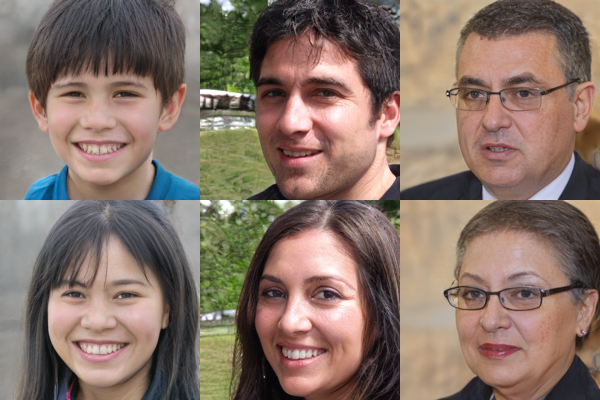

In [ ]:
#@title Move latent space

#@markdown direction age
age = 40 #@param {type:"slider", min:-0, max:72, step:1}
coeff_age = 0 #@param {type:"slider", min:0.0, max:2.0, step:0.1}

coeff_gender = -3.5 #@param {type:"slider", min:-4, max:4, step:0.1}

coeff_glasses_ReadingGlasses = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_glasses_SunGlasses = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_glasses_NoGlasses = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_hair_bald_0 = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_hair_bald_100 = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_facialHair = 0#@param {type:"slider", min:-2.0, max:2.0, step:0.1}

# # test
# direction = np.load('/content/drive/MyDrive/StyleGAN/latent_directions_v2/race_yellow.npy')
# seeds=[ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  #@param
# seeds=[ 20,21,22,23,24,25,26,27,28,29]  #@param
# seeds=[ 30,31,32,33,34,35,36,37,38,39]  #@param

#Genarate parameters (sample \[9870,4444,1008,1011,1012,1024,1025,1026])<br>
#[5, 1022,1023,1024,1025,1026,5,6,9]<br>
# Bald glasses: 2000, 2040, 2033,2044, 2064<br>

seeds = [33, 6008, 1023] #@param
# seeds = [i for i in range(2130, 2140)]

"""
seeds = []
seeds_from =  987 #@ param{type: "integer"}
seeds_to =  1005 #@ param{type: "integer"}
for i in range(seeds_from, seeds_to):
    seeds.append(i + seeds_from)
"""

truncation_psi = 0.7  #@param {type:"slider", min:-1.0, max:1.0, step:0.1}

#@markdown Image size
s = 200 #@param {type:"integer"}

# def _test(network_pkl, seeds=[1,2,3], truncation_psi=0.7, col_styles=None, minibatch_size=4):
network_pkl=model;  col_styles=None;  minibatch_size=4
w_avg = Gs.get_var('dlatent_avg') # [component]

Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = minibatch_size

z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in seeds]) # [minibatch, component]
w = Gs.components.mapping.run(z, None) # [minibatch, layer, component]
w = w_avg + (w - w_avg) * truncation_psi # [minibatch, layer, component]
new_direction = coeff_gender * direction_gender
new_direction += coeff_age * direction_ages[age]
new_direction += coeff_glasses_ReadingGlasses * direction_glasses_ReadingGlasses
new_direction += coeff_glasses_SunGlasses * direction_glasses_SunGlasses
new_direction += coeff_glasses_NoGlasses * direction_glasses_NoGlasses
new_direction += coeff_hair_bald_0  * direction_hair_bald_0
new_direction += coeff_hair_bald_100  * direction_hair_bald_100
new_direction += coeff_facialHair * direction_facialHair

#@markdown Layer
layer = "8" #@param[4,8,18]
layer = int(layer)
ww = w.copy()
ww[:,:layer] = (w + new_direction)[:,:layer]

images_org = Gs.components.synthesis.run(w, **Gs_syn_kwargs)
images_new = Gs.components.synthesis.run(ww, **Gs_syn_kwargs)
images_list = [images_org, images_new]

canvas = PIL.Image.new( mode='RGB', size=(s * len(seeds), s * 2))
for k, images in enumerate(images_list):
    for i, im in enumerate(images):
        img = PIL.Image.fromarray(im, 'RGB').resize((s,s))
        canvas.paste(img, (i * s, k * s))

# return canvas
# canvas = _test(network_pkl=model, seeds=[1,2,3,4], truncation_psi=0.7)
canvas

In [ ]:
#@title Make a movie

def make_movie():
    rate = 10
    input_path = 'img/image_%03d.png'
    output_path = 'transition.mp4'
    !ffmpeg -r $rate -y -i $input_path -vcodec libx264 -pix_fmt yuv420p -r $rate -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -loglevel 16 $output_path
    display(mpy.ipython_display(output_path, height=512, autoplay=1))

%cd /content/
%mkdir -p img
%rm -rf img/*

#@markdown direction glasses
coeff_glasses_ReadingGlasses = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_glasses_SunGlasses = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_glasses_NoGlasses = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}

coeff_hair_bald_0 = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}
coeff_hair_bald_100 = 0 #@param {type:"slider", min:-2.0, max:2.0, step:0.1}

coeff_facialHair = 0#@param {type:"slider", min:-2.0, max:2.0, step:0.1}
 
#@markdown direction age
age = 65 #@param {type:"slider", min:-0, max:72, step:1}
coeff_age = 0 #@param {type:"slider", min:0.0, max:2.0, step:0.1}
#@markdown direction_gender
coeff_gender = -4 #@param {type:"slider", min:-4, max:4, step:0.1}
# sample for udemy
seed = 33 #@param {type:"integer"}
truncation_psi = 0.7  #@param {type:"slider", min:-1.0, max:1.0, step:0.1}
#@markdown Image size
s = 512 #@param {type:"integer"}
network_pkl=model;  col_styles=None;  minibatch_size=4
w_avg = Gs.get_var('dlatent_avg') # [component]

Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = minibatch_size

n = 0
num_loop = 50
for k in range(0, num_loop):
    z = np.random.RandomState(seed).randn(*Gs.input_shape[1:]).reshape(1,-1)
    w = Gs.components.mapping.run( z, None) # [minibatch, layer, component]
    w = w_avg + (w - w_avg) * truncation_psi # [minibatch, layer, component]

    if coeff_gender > 0:
        coeff = k * -1 / num_loop
    else:
        coeff = k * 1 / num_loop


    new_direction = coeff * coeff_gender * direction_gender
    new_direction += coeff * coeff_age * direction_ages[age]
    new_direction += coeff * coeff_glasses_ReadingGlasses * direction_glasses_ReadingGlasses
    new_direction += coeff * coeff_glasses_SunGlasses * direction_glasses_SunGlasses
    new_direction += coeff * coeff_glasses_NoGlasses * direction_glasses_NoGlasses
    new_direction += coeff * coeff_hair_bald_0  * direction_hair_bald_0
    new_direction += coeff * coeff_hair_bald_100  * direction_hair_bald_100
    new_direction += coeff * coeff_facialHair * direction_facialHair

    layer = 8 
    ww = w.copy()
    ww[:,:layer] = (w + new_direction)[:,:layer]
    image = Gs.components.synthesis.run(ww, **Gs_syn_kwargs)
    im = PIL.Image.fromarray(image[0])
    im = im.resize((s,s))
    im.save('img/image_%03d.png' %n )
    n += 1

import moviepy.editor as mpy
make_movie()

/content


## 自分の顔で遊ぶ

さぁ、ここからがStyleGANの真骨頂ともいえる

ひとまず、これまでの環境の影響を受けないようにすべて1から作り直す
- 新しいノートブックに移ろう